# XML gaze data to pandas data and figures

## Import XML to dict

In [1]:
#additional helpful source:
#http://docs.python-guide.org/en/latest/scenarios/xml/

import xmltodict
import pandas as pd
import time

In [2]:
filepath = 'data_1_24_2018_11_25_05_AM_corrected.xml'

with open(filepath) as fd:
    xml = xmltodict.parse(fd.read())

In [3]:
'''Check the data structure'''
xml['Data']['Gaze'][0]

OrderedDict([(u'Left',
              OrderedDict([(u'Ray',
                            OrderedDict([(u'@PupilSize', u'0000.00238060'),
                                         (u'@valid', u'True'),
                                         (u'@timestamp',
                                          u'78975859099')]))]))])

In [4]:
'''Check the data structure'''
xml['Data']['GazePointCombined'][0]

OrderedDict([(u'@GazePointUnity',
              u'(0000.00000000, 0000.00000000, -0000.78000000)'),
             (u'@GazePointTobii',
              u'(-0000.01689851, 0001.24260700, -0002.57981500)'),
             (u'@TargetPosition',
              u'(0000.00000000, 0001.28000000, -0004.57000000)'),
             (u'@HeadPosition',
              u'(-0000.01523835, 0001.23875400, -0002.60477600)'),
             (u'@HeadRotation',
              u'(-0000.03917543, 0000.99902360, 0000.02023204, 0000.00278823)')])

In [5]:
len(xml['Data']['StageType']), len(xml['Data']['GazePointCombined'])

(29984, 29984)

In [6]:
xml['Data']['StageType'][0], xml['Data']['GazePointCombined'][0]

(OrderedDict([(u'@stage', u'0'), (u'@type', u'2')]),
 OrderedDict([(u'@GazePointUnity',
               u'(0000.00000000, 0000.00000000, -0000.78000000)'),
              (u'@GazePointTobii',
               u'(-0000.01689851, 0001.24260700, -0002.57981500)'),
              (u'@TargetPosition',
               u'(0000.00000000, 0001.28000000, -0004.57000000)'),
              (u'@HeadPosition',
               u'(-0000.01523835, 0001.23875400, -0002.60477600)'),
              (u'@HeadRotation',
               u'(-0000.03917543, 0000.99902360, 0000.02023204, 0000.00278823)')]))

## Dict to pandas

In [7]:
'''Read attributes to pandas format'''

start = time.time()

hx = [i['@GazePointUnity'][1:-2].split(",")[0] for i in xml['Data']['GazePointCombined']]
hy = [i['@GazePointUnity'][1:-2].split(",")[1] for i in xml['Data']['GazePointCombined']]
hz = [i['@GazePointUnity'][1:-2].split(",")[2] for i in xml['Data']['GazePointCombined']]
hs = [i['@stage'] for i in xml['Data']['StageType']] 
ht = [i['@type'] for i in xml['Data']['StageType']] 

mylist = zip (hx, hy, hz, hs, ht)

df=pd.DataFrame(mylist, columns=['gpu_x','gpu_y','gpu_z','stage','type'])

end = time.time()
print(end - start), ' seconds'

0.18700003624  seconds


In [8]:
df.head()

,gpu_x,gpu_y,gpu_z,stage,type
0,0000.00000000,0000.00000000,-0000.7800000,0,2
1,0000.00000000,0000.00000000,-0000.7800000,0,2
2,0000.00000000,0000.00000000,-0000.7800000,0,2
3,0000.00000000,0000.00000000,-0000.7800000,0,2
4,0000.00000000,0000.00000000,-0000.7800000,0,2


In [9]:
df.tail(2)

,gpu_x,gpu_y,gpu_z,stage,type
29982,-0006.82489000,-0033.89632000,-0200.6799000,4,2
29983,-0064.43005000,-0037.94939000,-0262.7061000,4,2


In [10]:
'''Check the length and data format'''
len(df), type(df.gpu_x[0])

(29984, unicode)

## Data massage

In [11]:
'''Remove extra white space and cpnvert to float format'''
cols = [i for i in df.columns]
df[cols] = df[cols].replace(' ','').astype(float)

In [12]:
'''Normed z value: inverse of (min-max scaling + .1)
.1 added to avoid 0'''
norm = lambda x: 1/(((x - x.min()) / (x.max()-x.min()))+.1)
df['gpu_nz'] = df['gpu_z'].transform(norm)

In [13]:
df['gpu_nz'].min(), df['gpu_nz'].max()

(0.90909090909090906, 10.0)

## Figures

In [14]:
import seaborn as sns
sns.set(style="white", color_codes=True)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

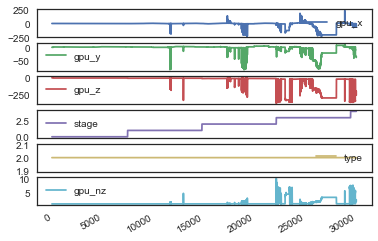

In [15]:
'''Just out of curiosity'''
df.plot(subplots=True);

### Plot x and y

In [16]:
#import seaborn as sns
import matplotlib.cm as cm

#### All-in-one

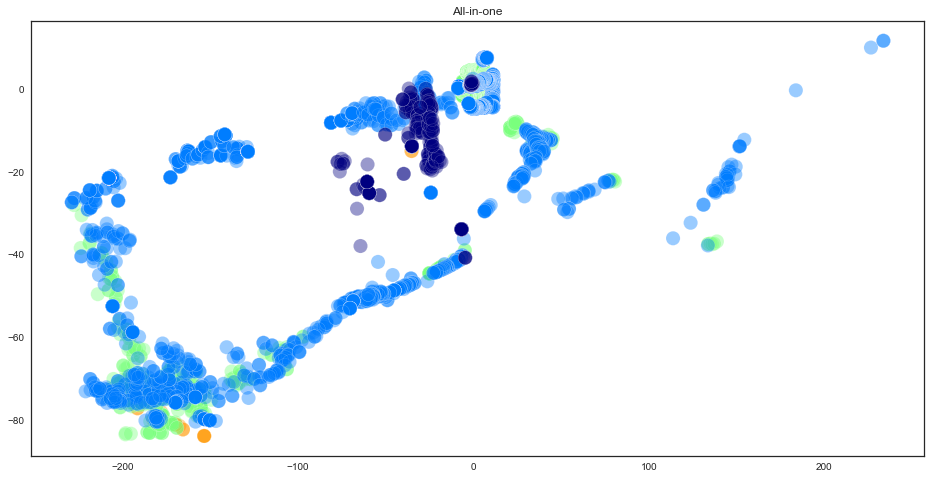

In [17]:
data = (['gpu'])
colors = ("green", "blue", 'red')
 
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1, 1, 1)
 
for data, color in zip(data, colors):
    x = df[data+'_x']
    y = df[data+'_y']
    ax.scatter(x, y, alpha=0.4, c=df['stage'], edgecolors='w', s=200, cmap='jet_r')
 
plt.title('All-in-one');
# plt.legend(loc=1)
#plt.savefig('all_in_one.png', format='png', dpi=300);

#### By stage

In [18]:
df.stage.unique()

array([ 0.,  1.,  2.,  3.,  4.])

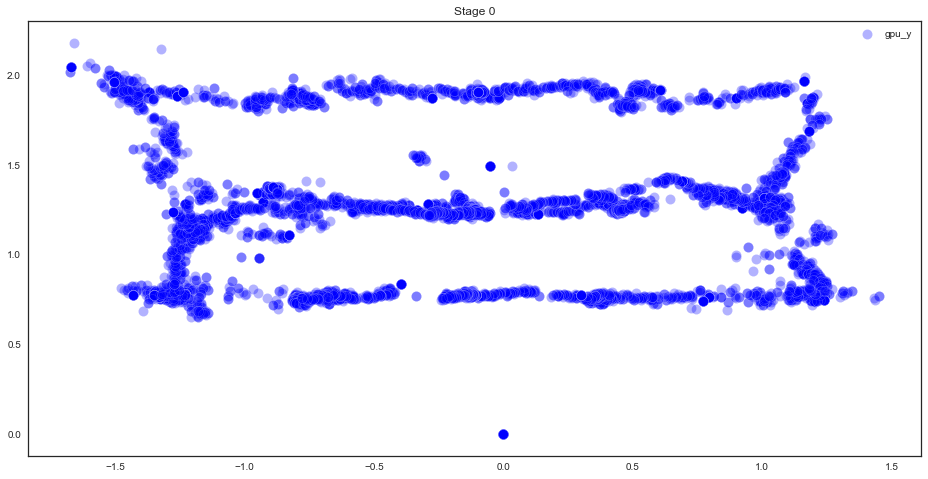

In [19]:
data = (['gpu'])
colors = (["blue"])
dfd = df[df.stage==0]
 
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1, 1, 1)
 
for data, color in zip(data, colors):
    x = dfd[data+'_x']
    y = dfd[data+'_y']
    ax.scatter(x, y, alpha=0.3, c=color, edgecolors='w', s=100)
 
plt.title('Stage 0')
plt.legend(loc=1);

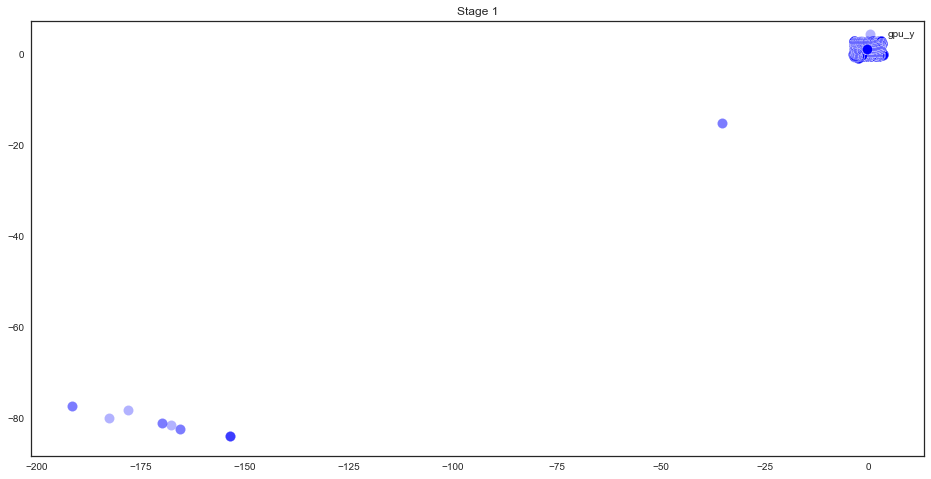

In [20]:
data = (['gpu'])
colors = (["blue"])
dfd = df[df.stage==1]
 
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1, 1, 1)
 
for data, color in zip(data, colors):
    x = dfd[data+'_x']
    y = dfd[data+'_y']
    ax.scatter(x, y, alpha=0.3, c=color, edgecolors='w', s=100)
 
plt.title('Stage 1')
plt.legend(loc=1);

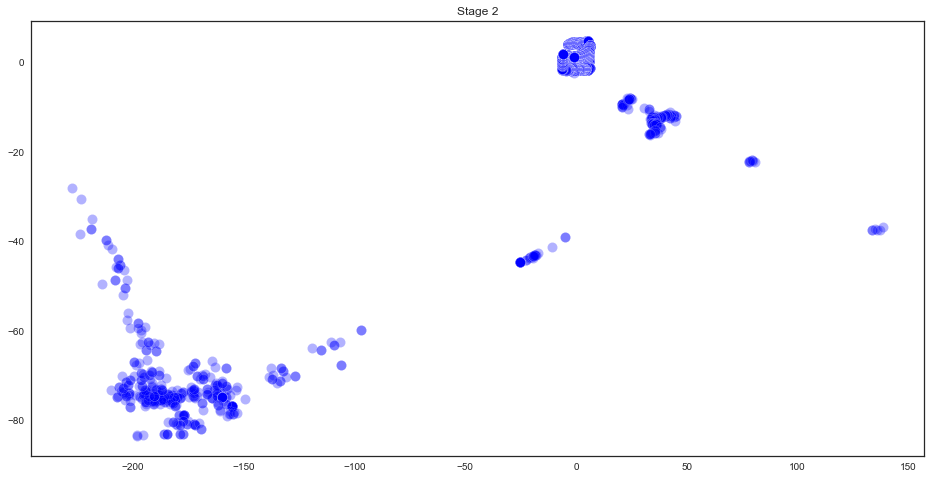

In [21]:
data = (['gpu'])
colors = (["blue"])
dfd = df[df.stage==2]
 
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1, 1, 1)
 
for data, color in zip(data, colors):
    x = dfd[data+'_x']
    y = dfd[data+'_y']
    ax.scatter(x, y, alpha=0.3, c=color, edgecolors='w', s=100)
 
plt.title('Stage 2')
# plt.legend(loc=1);

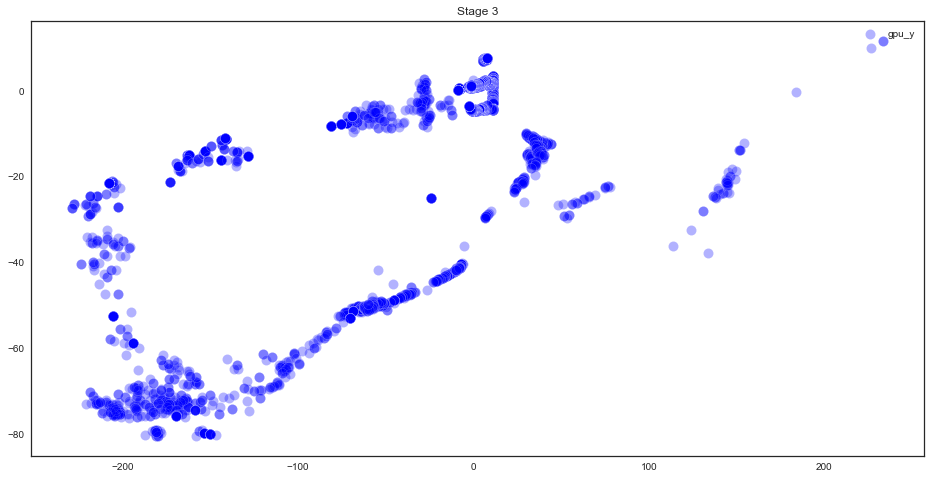

In [22]:
data = (['gpu'])
colors = (["blue"])
dfd = df[df.stage==3]
 
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1, 1, 1)
 
for data, color in zip(data, colors):
    x = dfd[data+'_x']
    y = dfd[data+'_y']
    ax.scatter(x, y, alpha=0.3, c=color, edgecolors='w', s=100)
 
plt.title('Stage 3')
plt.legend(loc=1);

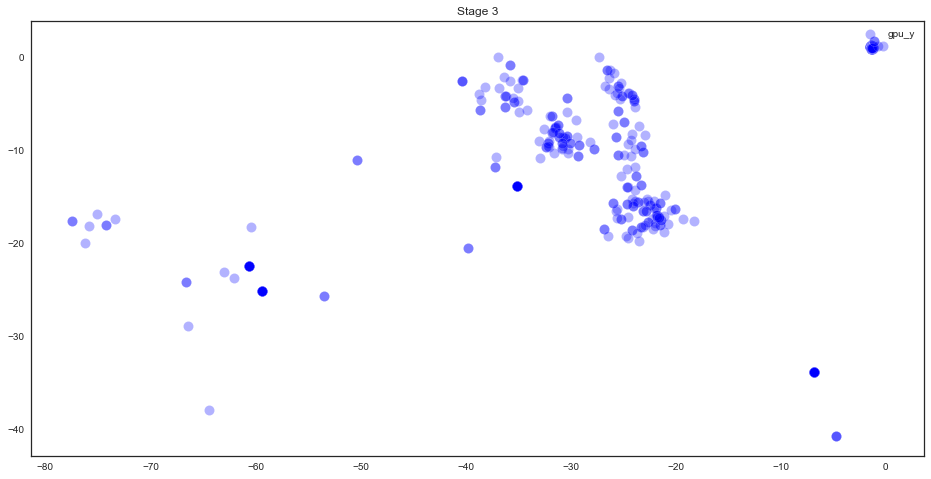

In [23]:
data = (['gpu'])
colors = (["blue"])
dfd = df[df.stage==4]
 
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1, 1, 1)
 
for data, color in zip(data, colors):
    x = dfd[data+'_x']
    y = dfd[data+'_y']
    ax.scatter(x, y, alpha=0.3, c=color, edgecolors='w', s=100)
 
plt.title('Stage 3')
plt.legend(loc=1);

### Plot x, y, z
z visualized as the point size

In [24]:
# data = (['gpu'])
# colors = (["blue"])
# dfd = df[df.stage==0]
 
# fig = plt.figure(figsize=(16,8))
# ax = fig.add_subplot(1, 1, 1)
 
# for data, color in zip(data, colors):
#     x = dfd[data+'_x']
#     y = dfd[data+'_y']
#     z = dfd[data+'_nz']
#     ax.scatter(x, y, alpha=0.3, c=color, edgecolors='w', s=50*z)
 
# plt.title('Stage 0')
# plt.legend(loc=1);
# # plt.savefig('gaze_data2_origin_z.png', format='png', dpi=300);

## Outlier removal from x and y

## Checks

In [25]:
len(df[(df.gpu_x<3)&(df.gpu_x>-3)]), len(df[(df.gpu_x<2.5)&(df.gpu_x>-2.5)])

(17275, 15325)

In [26]:
len(df[(df.gpu_y<3)&(df.gpu_y>-3)]), len(df[(df.gpu_y<2.5)&(df.gpu_y>-2.5)])

(22600, 20691)

In [27]:
n = 3
len(df[((df.gpu_x<n)&(df.gpu_x>-n))&((df.gpu_y<n)&(df.gpu_y>-n))])

16304

In [28]:
df = df[((df.gpu_x<n)&(df.gpu_x>-n))&((df.gpu_y<n)&(df.gpu_y>-n))]

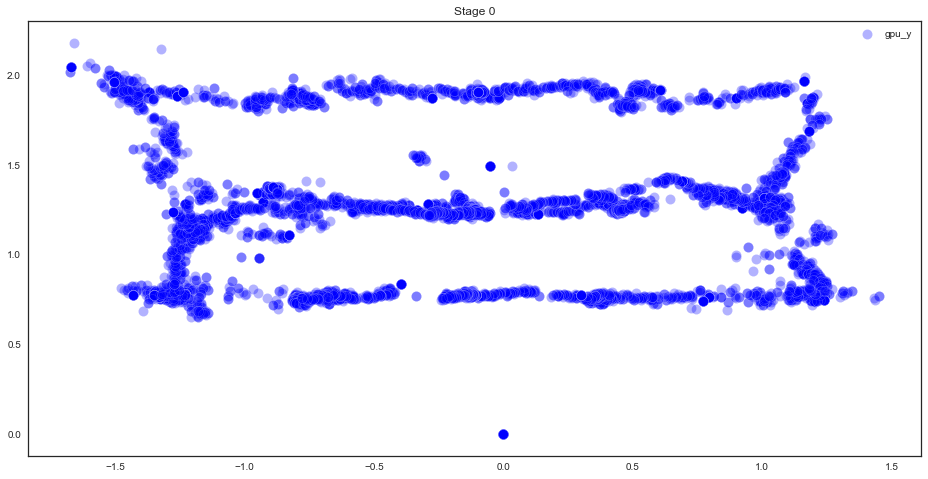

In [29]:
data = (['gpu'])
colors = (["blue"])
dfd = df[df.stage==0]
 
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1, 1, 1)
 
for data, color in zip(data, colors):
    x = dfd[data+'_x']
    y = dfd[data+'_y']
    ax.scatter(x, y, alpha=0.3, c=color, edgecolors='w', s=100)
 
plt.title('Stage 0')
plt.legend(loc=1);

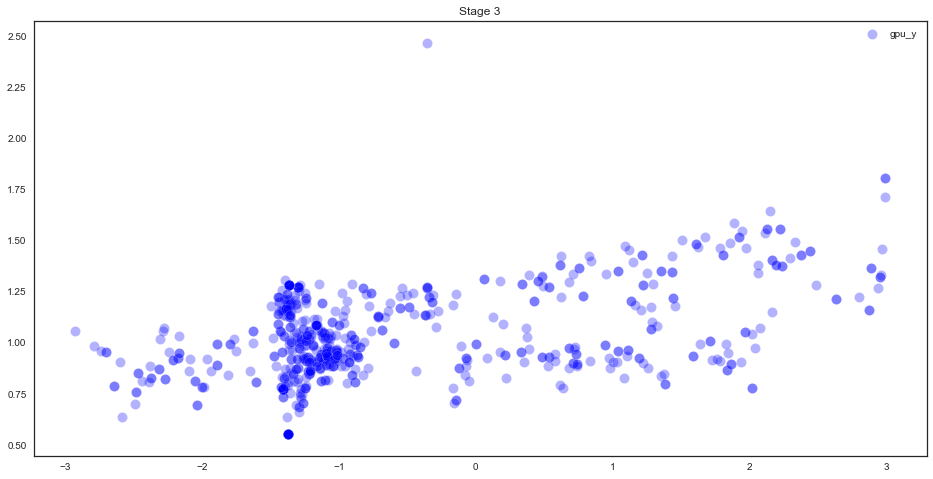

In [30]:
data = (['gpu'])
colors = (["blue"])
dfd = df[df.stage==3]
 
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1, 1, 1)
 
for data, color in zip(data, colors):
    x = dfd[data+'_x']
    y = dfd[data+'_y']
    ax.scatter(x, y, alpha=0.3, c=color, edgecolors='w', s=100)
 
plt.title('Stage 3')
plt.legend(loc=1);